# Incomplete Data 

Creating accurate predictions is one of the most valuable skills in the job market today. Statisticians, economists, and data scientists use data gathered from specific populations in order to predict the future. Through computational and statistical techniques, we can make _statistical inferences_ to draw conclusions from data that are often incomplete.

As far as estimations of parameters that already exist, having full population data would mean that our questions about that population are answered. But because the cost of gathering a full set of information typically outweigh the benefits of having perfectly accurate data, we are okay with use data samples to draw inferences about past data and predict future observations. 

## Are Mutual Funds better than Broad-market index funds? 

The term “index fund” refers to the investment approach of a fund. Specifically, it is a fund that that aims to match the performance of a particular market index, such as the S&P 500 or Russell 2,000. The index fund simply tries to match the market. This differs from a more actively managed fund, in which investments are picked by a fund manager in an attempt to beat the market. The age old question is: are the fees payed to an actively-managed mutual fund worth it? 

We could simply compare the mean return from a given date range for a mutual fund and compare it to the S&P500s mean return from the same time interval, and see which is higher. But the fact that mutual funds have a limited number of time intervals which we can sample means we cannnot rule out the possibility that higher or lower returns from the fund were a result of random variation, and not an indicator of the true quality of the fund. Returns to investment in the S&P500 is a quality proxy for returns in equity markets. Although returns to the S&P 500 experience stochasticity, on average the average rate of return from a mutual fund data should beat S&P returns on average if active investment is actually improving the rate of return. So, we need to analyze the two funds using statistical techniques which account for random variation that is possible from incomplete data. 

We would like to ananlyze which(if any) mutual funds have out-performed the market, fees included. To start, we read the CSV downloaded from [Stock Market MBA](https://stockmarketmba.com/listoftop100activelymanagedusstockmutualfunds.php), which shows the 100 largest actively-managed mutual funds in the US. 

In [1]:
import numpy as np
import pandas as pd

mutual_fund_data = pd.read_csv("Top100MutualFunds.csv")
mutual_fund_data

,Symbol,Name,Category1,Category2,Category3,Morningstar Category,Morningstar Rating,Market cap,Current yield,Fees,Action
0,AGTHX,American Funds The Growth Fund of America Class A,US Equity,Broad market,Large cap,Large Growth,3.0,"$138,592,080,000",0.22%,0.62%,Analyze
1,FCNTX,Fidelity Contrafund Fund,US Equity,Broad market,Large cap,Large Growth,3.0,"$121,762,870,000",0.00%,0.74%,Analyze
2,CWMAX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.46%,0.63%,Analyze
3,CWMCX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",0.79%,1.40%,Analyze
4,CWMEX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.28%,0.87%,Analyze
...,...,...,...,...,...,...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.51%,Analyze
96,FDYZX,Franklin DynaTech Fund Advisor Class,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.62%,Analyze
97,BBVLX,Bridge Builder Large Cap Value Fund,US Equity,Broad market,Large cap,Large Value,4.0,"$9,500,000,000",1.55%,0.25%,Analyze
98,PEYAX,Putnam Large Cap Value Fund Class A,US Equity,Broad market,Large cap,Large Value,4.0,"$9,393,340,000",1.23%,0.91%,Analyze


We don't need to include every category for each fund. Let's drop all categories except for the Morningstar Category. We'll also drop the Morningstar Rating and Action columns.

In [2]:
to_drop = [
    "Category2", "Category1", "Category3", "Morningstar Rating",
    "Current yield", "Action"
]
mutual_fund_data = mutual_fund_data.drop(columns=to_drop)
mutual_fund_data

,Symbol,Name,Morningstar Category,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,Large Growth,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,Large Growth,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.87%
...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,Large Growth,"$9,600,000,000",0.51%
96,FDYZX,Franklin DynaTech Fund Advisor Class,Large Growth,"$9,600,000,000",0.62%
97,BBVLX,Bridge Builder Large Cap Value Fund,Large Value,"$9,500,000,000",0.25%
98,PEYAX,Putnam Large Cap Value Fund Class A,Large Value,"$9,393,340,000",0.91%


The symbols column from *mutual_fund_data* contains the ticker symbol that we can use to download data from each fund.  If you have not yet done so, install the module using:

In [3]:
#!pip install pandas-datareader

Next we need to prepare to download the data. We can save the list of symbols and pass each symbol to pandas_datareader. We also need to choose the range of dates to include. Finally, we will save each fund in a dictionary using the ticker sympol as the key for data for that symbol.

In [4]:
import pandas_datareader as web
import datetime as dt

mutual_fund_dict = {}
symbols = mutual_fund_data["Symbol"][25:50]
# will only analyze the first 25 funds for now, but this should illustrate how to do it for any fund
start = dt.datetime(2013, 1, 1)
end = dt.datetime.today()
(start, end, symbols)

(datetime.datetime(2013, 1, 1, 0, 0),
 datetime.datetime(2022, 4, 20, 11, 16, 8, 486504),
 25    EAGRX
 26    AMRMX
 27    FMAGX
 28    HACAX
 29    FLPSX
 30    PRGFX
 31    PRNHX
 32    DFQTX
 33    DFEOX
 34    FLPKX
 35    RPMGX
 36    FOCPX
 37    CNGAX
 38    CNGCX
 39    CNGEX
 40    CNGFX
 41    FNEFX
 42    FOCKX
 43    DFLVX
 44    CDDRX
 45    CDDYX
 46    CDIRX
 47    CVIRX
 48    TWCUX
 49    EGFFX
 Name: Symbol, dtype: object)

Now we are ready to download the data. 

In [5]:
    #pull mutual fund data for the longest timeframe avaliable, and cpnvert to monthly percent change data
fund_data = web.DataReader(
    symbols, 
    'yahoo', 
    start=start,
    end=end) 

The column names have two layers. We are interested in the adjusted close data. Save this data as a unique dataframe, *close_data*, by selecting the key "Adj Close" from *fund_data*.

In [6]:
close_data = fund_data["Adj Close"]
close_data

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,CNGFX,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,18.406633,3.646204,19.298067,18.972300,22.592335,13.492072,9.629348,10.152753,18.787958,...,15.892828,NaN,3.046248,15.895295,10.270854,10.246215,10.132972,10.348704,16.299606,10.253462
2013-01-03,NaN,18.393919,3.634558,19.249228,18.920307,22.534077,13.523848,9.629348,10.144740,18.731752,...,15.870779,NaN,3.031177,15.848026,10.257394,10.232796,10.119551,10.341920,16.269072,10.253462
2013-01-04,NaN,18.463831,3.655909,19.302505,19.005383,22.592335,13.615195,9.698733,10.216857,18.820747,...,15.925904,NaN,3.038469,16.016842,10.297773,10.273055,10.159816,10.375829,16.293501,10.297753
2013-01-07,NaN,18.406633,3.648630,19.262552,18.991205,22.598162,13.619169,9.660187,10.176793,18.806698,...,15.931415,NaN,3.032635,15.942564,10.264121,10.239506,10.126261,10.348704,16.287394,10.290371
2013-01-08,NaN,18.330362,3.640866,19.249228,18.939209,22.557383,13.559592,9.629348,10.144740,18.750484,...,15.887316,NaN,3.011244,15.875038,10.230467,10.205957,10.092706,10.308014,16.281284,10.349426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12,64.430000,52.830002,12.990000,81.879997,52.459999,84.239998,58.660000,30.639999,33.830002,52.400002,...,50.060001,51.040001,16.740000,45.290001,31.010000,31.059999,30.480000,31.049999,74.809998,43.939999
2022-04-13,64.930000,53.090000,13.150000,83.660004,53.049999,86.139999,59.990002,31.030001,34.250000,52.990002,...,50.889999,51.880001,17.070000,45.680000,31.129999,31.180000,30.600000,31.170000,76.330002,44.709999
2022-04-14,64.800003,52.830002,12.900000,81.900002,52.950001,84.430000,58.580002,30.740000,33.919998,52.889999,...,50.080002,51.070000,16.700001,45.490002,30.940001,30.990000,30.410000,30.980000,74.849998,43.919998


We will want to compare the returns earned by each fund to the returns earned by investment in the S&P 500 index. We will save the S&P 500 data as a new column in the same data frame, *close_data*.

In [7]:
### for some reason the S&P 500 has two dates for today... not sure why or if it is a chance error...
close_data["S&P 500"] = web.DataReader(
    '^GSPC', 
    'yahoo', 
    start=start,
    end=end)['Adj Close'].iloc[:-1]
close_data

<ipython-input-7-2f12b1c59f72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data["S&P 500"] = web.DataReader(


Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,18.406633,3.646204,19.298067,18.972300,22.592335,13.492072,9.629348,10.152753,18.787958,...,NaN,3.046248,15.895295,10.270854,10.246215,10.132972,10.348704,16.299606,10.253462,1462.420044
2013-01-03,NaN,18.393919,3.634558,19.249228,18.920307,22.534077,13.523848,9.629348,10.144740,18.731752,...,NaN,3.031177,15.848026,10.257394,10.232796,10.119551,10.341920,16.269072,10.253462,1459.369995
2013-01-04,NaN,18.463831,3.655909,19.302505,19.005383,22.592335,13.615195,9.698733,10.216857,18.820747,...,NaN,3.038469,16.016842,10.297773,10.273055,10.159816,10.375829,16.293501,10.297753,1466.469971
2013-01-07,NaN,18.406633,3.648630,19.262552,18.991205,22.598162,13.619169,9.660187,10.176793,18.806698,...,NaN,3.032635,15.942564,10.264121,10.239506,10.126261,10.348704,16.287394,10.290371,1461.890015
2013-01-08,NaN,18.330362,3.640866,19.249228,18.939209,22.557383,13.559592,9.629348,10.144740,18.750484,...,NaN,3.011244,15.875038,10.230467,10.205957,10.092706,10.308014,16.281284,10.349426,1457.150024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12,64.430000,52.830002,12.990000,81.879997,52.459999,84.239998,58.660000,30.639999,33.830002,52.400002,...,51.040001,16.740000,45.290001,31.010000,31.059999,30.480000,31.049999,74.809998,43.939999,4397.450195
2022-04-13,64.930000,53.090000,13.150000,83.660004,53.049999,86.139999,59.990002,31.030001,34.250000,52.990002,...,51.880001,17.070000,45.680000,31.129999,31.180000,30.600000,31.170000,76.330002,44.709999,4446.589844
2022-04-14,64.800003,52.830002,12.900000,81.900002,52.950001,84.430000,58.580002,30.740000,33.919998,52.889999,...,51.070000,16.700001,45.490002,30.940001,30.990000,30.410000,30.980000,74.849998,43.919998,4392.589844


## Hypothesis Testing

To start, you formulate your __hypotheses__. These are mutually exclusive, falsifiable statements. Only one can be true, and one of them will be true. We create these two hypotheses: 

- The _null_ hypothesis $H_o$: The true means of the the sample populations do not differ.
- The _alternate_ hypothesis $H_a$: The true means of the sample populations do differ.

### 4 Steps of Hypothesis Testing

All hypotheses are tested using a four-step process:

1. State the two hypotheses so that only one can be right. 
2. Formulate an analysis plan, which outlines how the data will be evaluated.
3. Carry out the plan and physically analyze the sample data.
4. Analyze the results and either reject the null hypothesis, or state that the null hypothesis is plausible, given the data.

Hypothesis testing can be done mentally. It would be burdensome to have to state your _null_ and _alternate_ hypotheses, and run through these four steps explicitly every time you made a predictive computer model. The point is that in means testing, there is a clear process and result that deliniates "Yes, the true means of these samples are different" and "No, they're not significantly different"

In the case of us determining the efficacy of an investment strategy, we must compare the return on strategy to the average return approximated by returns on investment in the S&P 500. These are our hypotheses: 

- $H_o$: There is no difference between the mutual fund's and S&P500's average monthly return. 
- $H_a$: The mutual funds have a higher mean gain than the S&P500. 

Since data for many of the funds considered do not span many years, we will compare monthly returns for each fund to monthly returns to the S&P 500.

We prepare this data by resampling the data by month.We calculate monthly returns for each portfolio using the *.pct_change()* method.

In [8]:
# create empty dictionary to hold average yearly gain for each mutual fund
monthly_data = close_data.resample(
        "M").first()
monthly_data

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,NaN,18.406633,3.646204,19.298067,18.972300,22.592335,13.492072,9.629348,10.152753,18.787958,...,NaN,3.046248,15.895295,10.270854,10.246215,10.132972,10.348704,16.299606,10.253462,1462.420044
2013-02-28,NaN,18.946884,3.768974,19.733128,19.709639,23.064222,14.250681,10.084216,10.601493,19.518679,...,NaN,3.111879,16.766363,10.647766,10.621979,10.495342,10.735251,16.672134,10.674230,1513.170044
2013-03-31,NaN,19.188406,3.773826,19.675413,19.676554,23.180738,14.421464,10.115056,10.641559,19.485891,...,NaN,3.105558,16.779873,10.789107,10.762889,10.629554,10.870886,16.708776,10.718522,1518.199951
2013-04-30,NaN,19.840748,3.855834,20.052765,20.465879,23.565239,14.790840,10.454556,10.988852,20.272820,...,NaN,3.163411,17.470095,11.105442,11.071548,10.989862,11.189619,16.898096,10.895686,1562.170044
2013-05-31,NaN,20.313608,3.875244,20.447868,21.094515,23.862352,14.890133,10.462285,11.037048,20.895809,...,NaN,3.259669,17.551380,11.394859,11.360077,11.272862,11.481227,17.179016,10.910449,1582.699951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,61.910000,49.557335,14.854959,100.671051,50.059002,104.872025,76.353806,31.117332,34.374695,49.992012,...,59.874592,19.578415,42.995403,30.007641,30.050837,29.561466,30.048225,84.689278,55.059811,4513.040039
2022-01-31,65.070000,52.907974,15.290000,101.989998,54.090000,106.559998,75.900002,33.160000,36.630001,54.009998,...,62.110001,20.170000,46.330002,32.013771,32.059631,31.517231,32.058918,88.860001,56.709999,4796.560059
2022-02-28,65.059998,52.180889,13.770000,89.800003,52.700001,94.559998,65.660004,31.549999,34.860001,52.639999,...,55.279999,18.260000,45.790001,31.048182,31.084208,30.550381,31.083212,80.550003,50.099998,4546.540039


In [9]:
monthly_returns = monthly_data.pct_change().dropna()
avg_monthly_returns = monthly_returns.mean()
avg_monthly_returns

Symbols
EAGRX      0.006142
AMRMX      0.009672
FMAGX      0.013027
HACAX      0.016211
FLPSX      0.009574
PRGFX      0.013432
PRNHX      0.016062
DFQTX      0.011750
DFEOX      0.012200
FLPKX      0.009647
RPMGX      0.011413
FOCPX      0.017416
CNGAX      0.010087
CNGCX      0.009446
CNGEX      0.009882
CNGFX      0.010271
FNEFX      0.010395
FOCKX      0.017499
DFLVX      0.008622
CDDRX      0.010820
CDDYX      0.010864
CDIRX      0.010347
CVIRX      0.010765
TWCUX      0.018270
EGFFX      0.015008
S&P 500    0.011883
dtype: float64

In [10]:
# I think we can drop the annual data due to low n problem...
yearly_returns = close_data.resample(
        "Y").first().pct_change().dropna()
yearly_returns

Symbols,EAGRX,AMRMX,FMAGX,HACAX,FLPSX,PRGFX,PRNHX,DFQTX,DFEOX,FLPKX,...,FNEFX,FOCKX,DFLVX,CDDRX,CDDYX,CDIRX,CVIRX,TWCUX,EGFFX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,-0.115169,-0.029867,-0.063666,-0.029228,-0.112025,-0.022835,0.021522,-0.100994,-0.083484,-0.111332,...,-0.060386,-0.042638,-0.119937,-0.046254,-0.045815,-0.051616,-0.047012,-0.002640,0.006479,-0.068914
2020-12-31,0.210248,0.224195,0.323838,0.356085,0.255928,0.330258,0.405971,0.296864,0.307270,0.257108,...,0.287946,0.409420,0.253713,0.291242,0.292614,0.284042,0.291062,0.363149,0.349707,0.297933
2021-12-31,0.080210,0.030893,0.248287,0.502424,0.083747,0.321619,0.530809,0.134253,0.140425,0.084737,...,0.306576,0.426650,-0.022753,0.057086,0.057563,0.051301,0.056255,0.453763,0.381629,0.135918
2022-12-31,0.125876,0.265221,0.285932,0.181919,0.261899,0.223392,0.105272,0.307599,0.299317,0.262762,...,0.139003,0.277838,0.302432,0.280413,0.280966,0.273119,0.279623,0.270562,0.246448,0.296140


# <font color='green'>Unclear if you are talking about a sample or a sample of the means from n > 30 samples. You could be looking at non-normal distributions in the first case.</font>

##### T Distributions
All of the t-distributions below are normal distributions. As the degrees of freedom increases past 30 or so, the distribution becomes the _standard normal distribution_(see Central Limit Theorem below), which has a standard deviation of 1 and mean of 0, and we use z-scores to analyze this. 

__The $t$ value tells us how many standard deviations away from the mean our sample sits on a $t$ distribution of the _differences_ of these two means, where the mean of the distribution is zero.__
The t-distribution changes based on sample size, as increased sample size allows for higher _degrees of freedom_, which are defined for two samples as: 

- $df = (N_1 + N_2)  – 2$

And for a single sample as: 

- $df = N - 1$

# <font color='green'>Same concern here. Not all distributions are standard normal. Central limit theorem refers to a sample of sample means. This is clarified following example. </font>
# Comparisons of Means

When dealing with a population of known parameters $\mu$ and $\sigma^2$, we can take any mean $\bar{X}$ gotten from a sample and determine the likelihood that the sample came from out known population, or a population with same mean as our known population. We do this using a z-score: 
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\sigma}$
    </font>
</h3>

### Central Limit Theorem:


If $\bar{X}$ is the mean of a random sample of size $n$ taken
from a population with mean $\mu$ and finite variance $\sigma^2$, then the limiting form of
the distribution of
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}}$
    </font>
</h3>

 as $\lim_{n \to \infty}$, is the *standard normal distribution* 
 
 The power of the CLT is that this holds no matter the type of distribution we are sampling from. So, for instance, if we took 30 random samples from a lognormal distribution, the means of the samples would be normally distributed. 

# <font color='green'>Maybe it would be good to use bootstrapping as example here in a following example to generate a normal distribution from a single non-normal distribution. </font>


 The Z-value tells us: what is the probability that a given sample mean would occur given the sample size and population mean? As n gets larger, the mean is expected to get more accurate if it does follow the population mean $\mu$
 
The gotten _z-score_ tells us how many standard deviations our sample mean $\bar{X}$ is from our population mean $\mu$.
 
 The normal approximation for $\bar{X}$ will generally be good if $n$ ≥ 30, provided the population distribution is not terribly skewed. If $n$ < 30, the approximation is good only if the population is not too different from a normal distribution and, as stated above, if the population is known to be normal, the sampling distribution of $\bar{X}$ will follow a normal distribution exactly, no matter how small the size of the samples.
 
For the following demonstration, [ImageMagick](https://imagemagick.org/script/download.php#windows) must be installed as well as wand through pip install. 

In [11]:
# !pip install wand

# must install ImageMagick as well; but not necessary if you just want to view the plot included.

In [12]:
# Central Limit Theorem
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation as animation
# from IPython import display
# number of simulations of die roll
n = 500

# In each simulation, there is one trial more than the previous simulation
dist_avgs = {"Die Rolls":[],
            "Possoin":[]}

for i in range(n):
    dist_avgs["Die Rolls"].append(np.average(np.random.randint(1,7,n)))
    dist_avgs["Possoin"].append(np.average(np.random.poisson(1, n)))
dist_avgs = pd.DataFrame(dist_avgs)

dist_avgs


,Die Rolls,Possoin
0,3.622,0.996
1,3.566,0.980
2,3.474,1.016
3,3.396,0.928
4,3.610,0.964
...,...,...
495,3.380,1.004
496,3.412,0.994
497,3.444,1.036
498,3.394,1.026


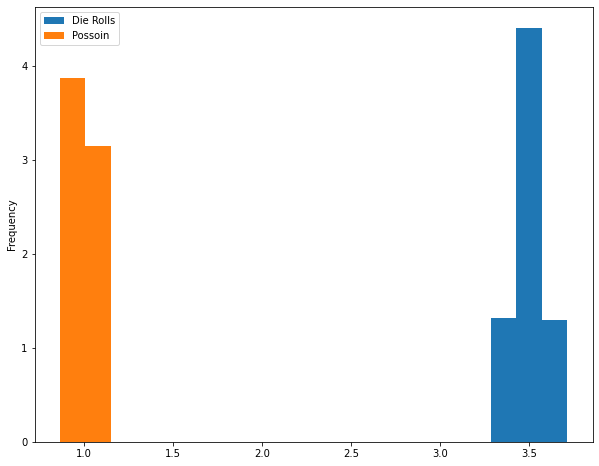

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
dist_avgs.plot.hist(density = True, ax = ax, bins = 20)
plt.show()

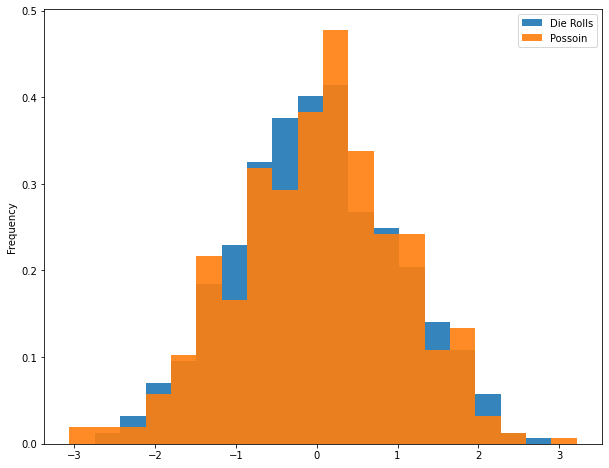

In [14]:
# transform values into standard deviations
sd_df = dist_avgs
for key in dist_avgs:
    sd_df[key] = dist_avgs[key] - dist_avgs.mean()[key]
    sd_df[key] = dist_avgs[key].div(dist_avgs.std()[key])
fig, ax = plt.subplots(figsize = (10,8))
sd_df.plot.hist(density = True, ax = ax, bins = 20, alpha = .9)
plt.show()

<IPython.core.display.Javascript object>


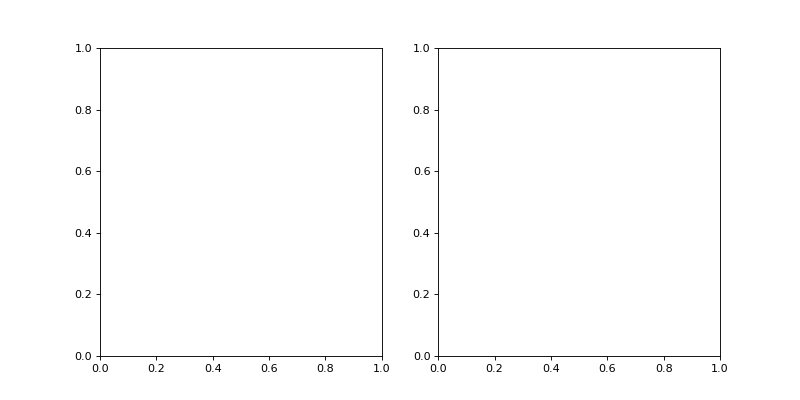

In [15]:
%matplotlib notebook
# Function that will plot the histogram, where current is the latest figure
def clt(current, *kwargs):
    # if animation is at the last frame, stop it
    if current == n:
        a.event_source.stop()

    for i in range(len(dist_avgs.keys())):
        ax[i].clear()
        dist = list(dist_avgs.keys())[i]
        sd_df[dist].iloc[:current].plot.hist(density = True,
                                                 color = "C" + str(i),
                                             bins= int(current/10 + 1),
                                             ax = ax[i])
#         ax[i].hist(dist_avgs[dist][0:current], bins= int(current/10 + 1))
        title = dist+'\n# Samples = {}'
        ax[i].set_title(title.format(current))
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].set_ylim(bottom = 0, top = .55)

#     plt.annotate('Die roll = {}'.format(current), [3,27])
fig, ax = plt.subplots(1,2, figsize = (10,5))
xlabel, ylabel = 'Sample Average Value', 'Density'
kwargs = (ax, xlabel, ylabel, n, sd_df)
a = animation(fig, clt, interval=20, frames=n, fargs = kwargs)
# video = a.to_html5_video()
# html = display.HTML(video)
# display.display(html)
plt.show()

In [16]:
# a.save('clt2.gif', writer='imagemagick', fps=25)

This is the gif we just produced, embedded: 

<img src="clt2.gif">

So, for any sample with $n$ > 30, $\bar{x}$ can be substituted for $\mu$ and $s$ can be substituted for $\sigma$
 
This Z-test asunes that we have access to the population standard deviation and mean _or_ that $n$ is large enough (>30) for $s^2$ and $\bar{x}$ to be used as a reliable estimate for $\sigma^2$ and $\mu$. When these conditions do not hold, and we do not have a large enough sample or sufficient population data, we need another estimator.  
 

The __T-test__ is used when we are dealing with a population of unknown distribution, and would like to compare a given sample mean to one of three options: 

- **One Sample T-test:** The one sample t test compares the mean of your sample data to a known value. For example, you might want to know how your sample mean compares to the population mean, like our value of 120,000 for average mothly store revenue
<h3 align="center">
    <font size="7">
        $ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
    
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    

- **Independent Samples T-test:** The The independent samples t test (also called the unpaired samples t test) is the most common form of the T test. It helps you to compare the means of two sets of data. Normally, we are checking to see if the means of the data are significantly different from a differnece of zero. But , we can also check if they are significantly different from a hypothesized or theoretical value. For instance, say we had two groups of males and one group of females and we wanted to compare average heights between the groups. For the males, we would check to see if they differed significantly from an average height difference of zero, whereas when comparing the males to the females we may want to see if they were significantly different from an average difference of 2 inches, or whatever the average height between males and females is. **This hypothesized difference, $(\mu_1 - \mu_2)$, will usually be zero, but not always.**

<h3 align="center">
    <font size="7">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 
    
   
   - Note that this t-test is one variation of the independent samples t-test that _does not_ assume equal variance between the samples
   
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    
    
- **Paired Samples T-test:** A paired t test (also called a correlated pairs t-test, a paired samples t test or dependent samples t test) is where you run a t test on dependent samples. Dependent samples are essentially connected — they are tests on the same person or thing. This would be useful if we chose a random sample of stores and measured their mean revenues before and after implementation of the new marketing campaign as our two means. For our function, we can simply add an optional argument "equal_var" to our independent t-test funtion which will cause it to act like a paired samples t-test. 

The t-value we obtain will lie on the horizontal axis of our t-distribution, representing the number of standard deviations the difference between our sample mean and theoretical mean lies from zero, with a corresponding p-value on the y-axis that tells us how likely our result would be if the population our sample was drawn from had the same mean as our theorized or population mean. This t-distribution takes the form: 
<h3 align="center">
    <font size="6">
        $ f(T) = \frac{(1 + \frac{T^2}{\nu})^{\frac{-(\nu+1)}{2}}}{B(0.5,0.5\nu)\sqrt(\nu)}$
    </font>
    </h3> 
    
    
- Where $\nu$ is the degrees of freedom of the distribution and B is the beta function, which is beyond the scope of this book and can be pulled from the scipy.stats library. 

### T-distribution p-value

As we can see, a lower sample size, and hence a lower degrees of freedom, leads to a lower probaility that our t-score is near 0 when our population means are the same, because more random variation is likely when the sample size is so low. The point of a t-score is to determine if the difference in the two means of the samples is too drastic for the true population means to be the same. As we approacch 30 with our degrees of freedom, the graph doesnt change much, and this is a standard normal distribution, which the z-score uses. That is why we use z-score for large sample sizes. 

Once we get our t-score based on the t-distribution, shown on the x-axis of the above graph, we get a corresponding __p-value__, shown on the y-axis. This value is the probability of our gotten t-value if the true means were the same. 

- If the corresponding p-value from our t-value is too low, we choose to __reject the null hypothesis $H_o$__, and say that our samples come from different populations who's means are different. This is a "statistically significant" result. 


- If the p-value is sufficiently high, we __fail to reject the null hypothesis $H_o$__, and say that there is a high enough chance that the samples came from populations with the same means. This is a "statistically insignificant" result. 


- The value at which a non-significant result becomes a significant one is called the __*critical value*__, denoted $\alpha$, and is most commonly 0.05.

We now implement the theory into code: 

First, we create a funtion that uses a flat np.linspace array from -10 to 10(very extreme t vaues) and transform it according to the t-distributions density function:

In [17]:
import datlib.stats
import scipy.special as sc
import scipy.stats as stats


# define a function to create the actual distribution from which we can analyze our t value from the t test
def create_t_distribution(df):
    x = np.linspace(-5, 5, 1000)  # large number of points will ensure accuracy
    # transform flat array of x values into t distribution
    t_distribution = ((1 + x**2 / df)
                      **(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    return t_distribution

<IPython.core.display.Javascript object>


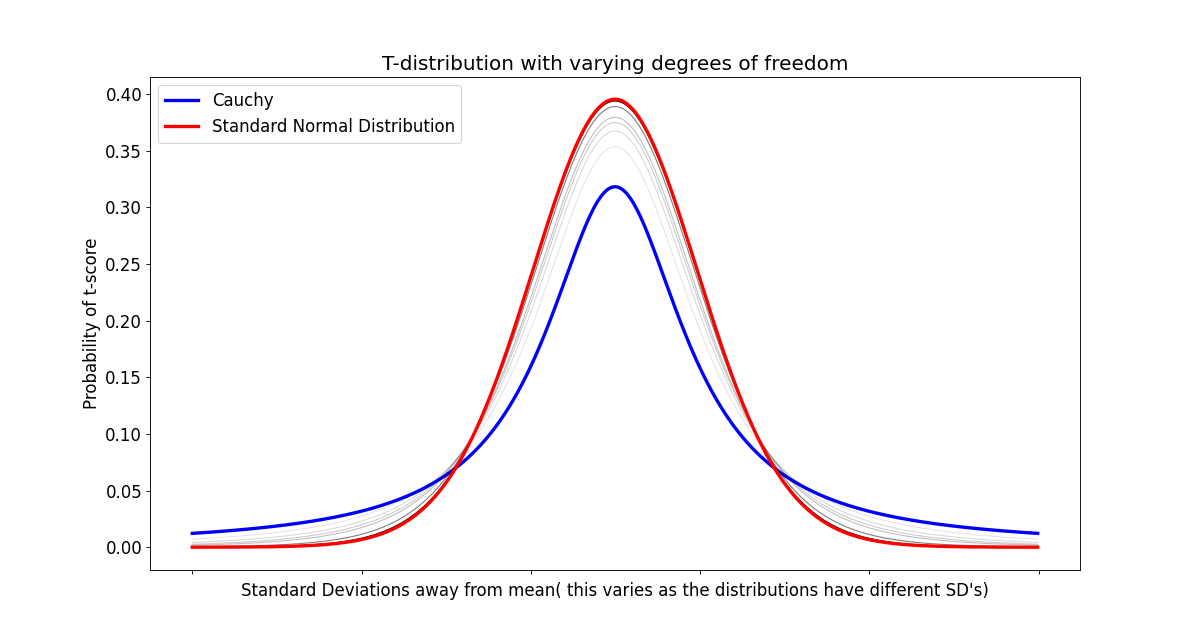

In [38]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
cauchy = create_t_distribution(1)
ax.plot(cauchy, '-', lw=3, alpha=1, label="Cauchy", color='b')
t_df = [2, 3, 4, 5, 10, 20]
for df in t_df:
    dist = create_t_distribution(df)
    ax.plot(dist, '-', lw=1, alpha=df / 20, color='k')
gaussian = create_t_distribution(30)
ax.plot(gaussian,
        lw=3,
        alpha=1,
        color='r',
        label='Standard Normal Distribution')
plt.rcParams.update({"font.size": 15})
ax.set_ylabel("Probability of t-score")
ax.set_xlabel(
    "Standard Deviations away from mean( this varies as the distributions have different SD's)"
)
plt.title("T-distribution with varying degrees of freedom")
ax.set_xticklabels(labels="")
plt.legend(loc = 2)
plt.savefig("tdist.png")
plt.show()

In [19]:
# function that allows us to evaluate the t distribution at a given t value and df
def t_prob(t, df):
    p_value = stats.t.sf(t, df)
    # equivalent to = ((1 + t**2 / df)**(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    return p_value

Next, we create a function that will calculate a t value from a given sample set and $\mu$ value and output the t value and its corresponding p-value from the distribution we created. 

In [20]:
from datlib.stats import *


def ttest_one_sample(data, mu):
    x_bar = mean(data)
    s = SD(data, sample=True)
    n = len(data)
    df = n - 1
    t = (x_bar - mu) / (s / np.sqrt(n))
    p_value = t_prob(t, df)
    if p_value > .05:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

    return return_string

To show the utility of the single-sample t-test, we can check to see if the S&P500's average yearly return was significantly different from some arbitrary value, like 10%. Can we confidently say that the S&P500's return was different from 10%, or could the observed difference have been due to random variation? 

In [21]:
sp500 = monthly_returns["S&P 500"]
ttest_one_sample(sp500, .10)


'T-value: -11.241504251140618, P-value: 0.9999999999999987, Fail to reject null hypothesis.'

We can test our results vs the SciPy library's one sample t test: 

In [22]:
stats.ttest_1samp(sp500, .10)

Ttest_1sampResult(statistic=-11.24150425114062, pvalue=2.710016716974849e-15)

And the results are essentially the same, but the loss of significant figures many decimal places out become multiplied later on in our function to give slightly different results. 

From the test, we fail to reject our null hypothesis that the average yearly S&P500 gain was not significantly different from 10%. 

In [23]:
# independent samples t-test, setting equal_var=True will turn this test into a paired samples t-test where equal variance
# is assumed
def ttest_ind_samp(a,
                   b,
                   hypothesized_difference=0,
                   equal_var=False,
                   show_distributions=True):
    s1 = variance(a)
    s2 = variance(b)
    n1 = len(a)
    n2 = len(b)
    # if paired samples, function is simpler
    if (equal_var):
        df = n1 + n2 - 2
        svar = ((n1 - 1) * s1 + (n2 - 1) * s2) / float(df)
        denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
    else:
        vn1 = s1 / n1
        vn2 = s2 / n2
        df = ((vn1 + vn2)**2) / ((vn1**2) / (n1 - 1) + (vn2**2) / (n2 - 1))
        denom = np.sqrt(vn1 + vn2)

    x_bar1 = np.mean(a)
    x_bar2 = np.mean(b)
    d = np.mean(a) - np.mean(b) - hypothesized_difference
    t = d / denom
    #df_approx = round(df, 0)
    # t = ((x_bar1 - x_bar2) - (hypothesized_difference)) / (np.sqrt( (s1 / n1) + ( s2 / n2)))

    if (show_distributions):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        a.plot.kde(ax=axs[0], label="Group1 distribution", legend=True, color='b')
        a.plot.hist(ax=axs[0], bins=5, density=True, alpha=0.1, color='b')
        b.plot.kde(ax=axs[0], label="Group2 distribution", legend=True, color='r')
        b.plot.hist(ax=axs[0], bins=5, density=True, alpha=0.1, color='r')
        
        dataframe = pd.DataFrame(columns = ["Group1", "Group2"])
        dataframe["Group1"] = a
        dataframe["Group2"] = b
        dataframe.boxplot(grid=False, ax = axs[1])
        

    p_value = t_prob(t, df)
    if p_value > .05:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

    return return_string

In [24]:
i = 0
for key in yearly_returns.keys():
    print("\n" + key + ": ")
    print(stats.ttest_ind(monthly_returns[key], sp500, alternative="less"))
    i += 1
    if i == 7:
        break


EAGRX: 
Ttest_indResult(statistic=-0.5869815437865542, pvalue=0.27926950038696974)

AMRMX: 
Ttest_indResult(statistic=-0.22281544266294612, pvalue=0.41206681604290485)

FMAGX: 
Ttest_indResult(statistic=0.1013555846671654, pvalue=0.5402644300790944)

HACAX: 
Ttest_indResult(statistic=0.34307735111690396, pvalue=0.6338697786178707)

FLPSX: 
Ttest_indResult(statistic=-0.20364825348134585, pvalue=0.4195211132136015)

PRGFX: 
Ttest_indResult(statistic=0.1309391972300989, pvalue=0.5519567671175627)

PRNHX: 
Ttest_indResult(statistic=0.33937356693461646, pvalue=0.632479991373398)



EAGRX: 


<IPython.core.display.Javascript object>


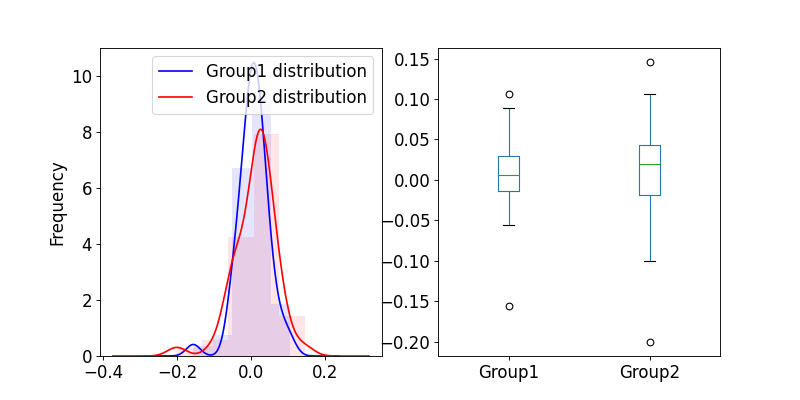

T-value: -0.59282230001997, P-value: 0.722626769908733, Fail to reject null hypothesis.

AMRMX: 


<IPython.core.display.Javascript object>


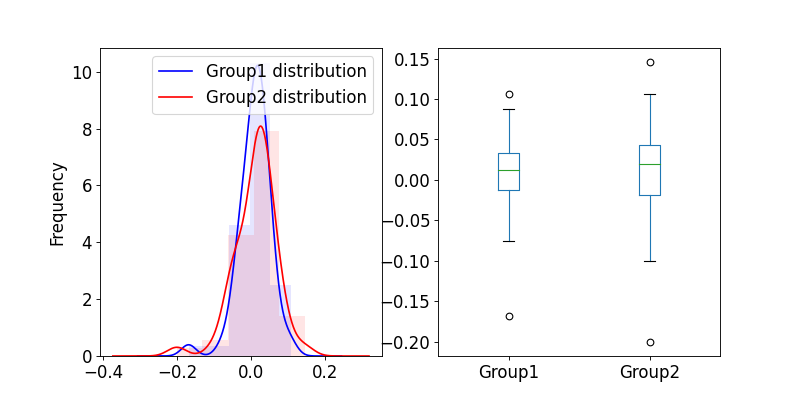

T-value: -0.22503256635177568, P-value: 0.5887793890753552, Fail to reject null hypothesis.

FMAGX: 


<IPython.core.display.Javascript object>


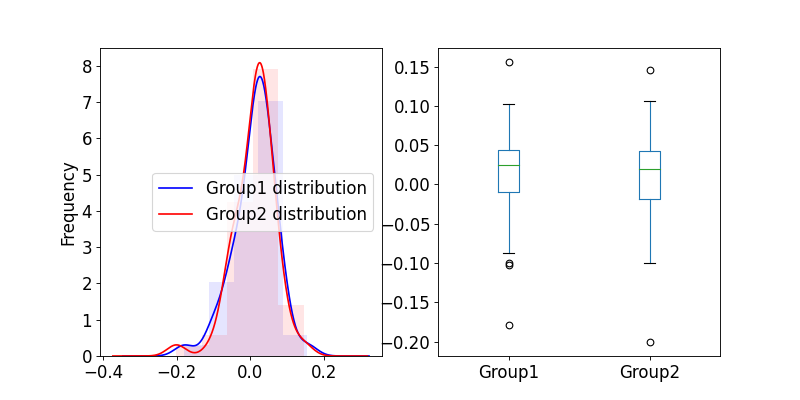

T-value: 0.10236412278766126, P-value: 0.45933645238426957, Fail to reject null hypothesis.

HACAX: 


<IPython.core.display.Javascript object>


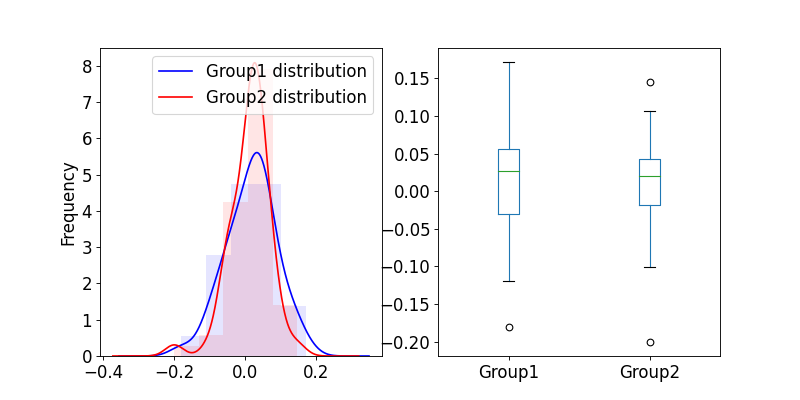

T-value: 0.3464911401845352, P-value: 0.36486965881735606, Fail to reject null hypothesis.

FLPSX: 


<IPython.core.display.Javascript object>


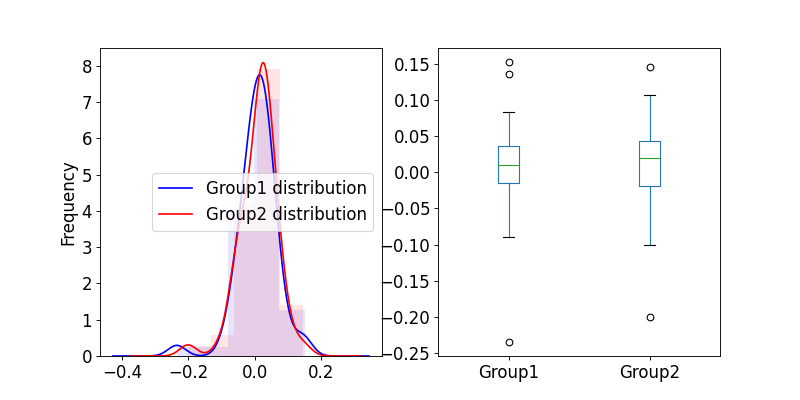

T-value: -0.2056746541723664, P-value: 0.581267995720402, Fail to reject null hypothesis.

PRGFX: 


<IPython.core.display.Javascript object>


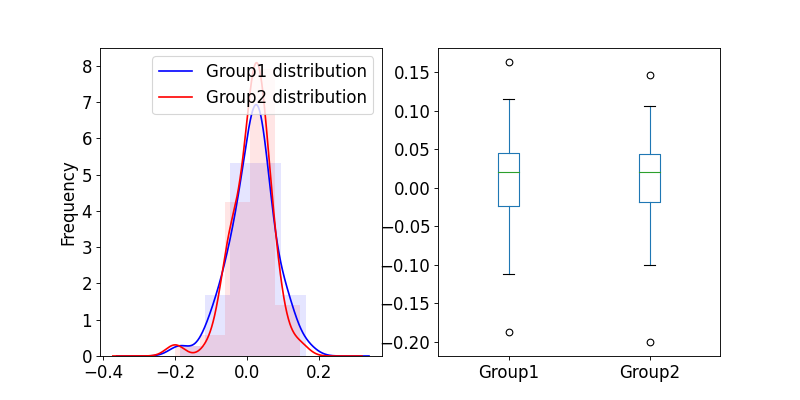

T-value: 0.13224210690505495, P-value: 0.4475312166024765, Fail to reject null hypothesis.

PRNHX: 


<IPython.core.display.Javascript object>


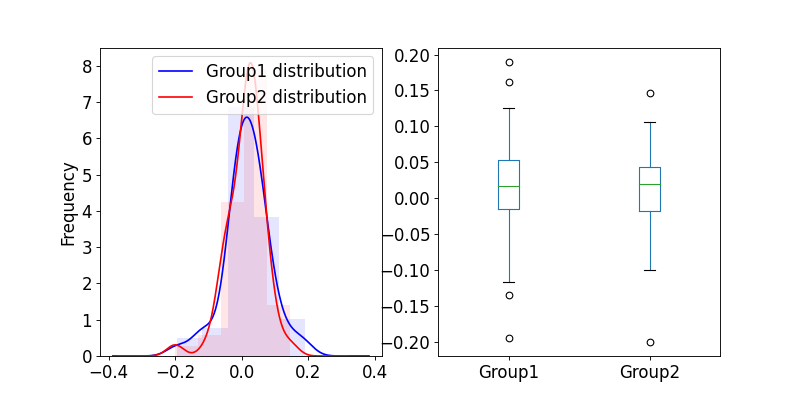

T-value: 0.34275050152057057, P-value: 0.36626571435094757, Fail to reject null hypothesis.


In [25]:
i = 0
for key in monthly_returns.keys():
    print("\n" + key + ": ")
    result = ttest_ind_samp(monthly_returns[key], sp500)
    print(result)
    i += 1
    if i == 7:
        break

The results are not exactly the same but they are reasonably close 

<IPython.core.display.Javascript object>


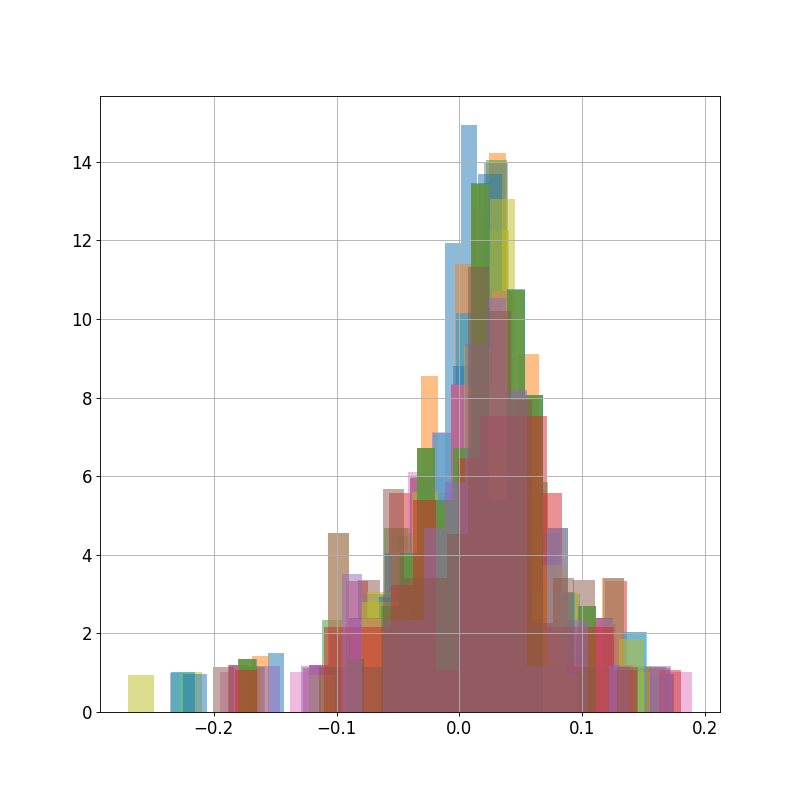

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
for key in monthly_returns:
    monthly_returns[key].hist(density = True, alpha=.5, legend = False, ax = ax, bins = 20)
    plt.show()

# ANOVA 

While using T-tests and Z-tests to analyze means of groups, we were restricted to only being able to compare two groups at a time. What if we wanted to see of there was significant differences between more than two groups? The **ANOVA**, or **Analysis of Variance** techniques allow us to test the null hypothesis that there is no significant difference between $k$ (some integer larger than 2) groups. 

- $H_o$: $\mu_1 = \mu_2 = \cdots = \mu_k$
- $H_a$: At least two of the means are not equal. 

### Assumptions needed for ANOVA
There are three assumptions that must be met in order to carry out an ANOVA test: 

1. The experimental errors of yoyr data are normally distributed
2. Homoscedasticity - the variances of your factors are all roughly the same (and at least follow the same distribution)
3. Samples are independent - Selection of one sample had no effect on any other sample

### F-Statistic
The distribution used for the hypothesis test is a new one. It is called the F distribution, named after Sir Ronald Fisher, an English statistician. The F-statistic is a ratio. There are two sets of degrees of freedom; one for the numerator and one for the denominator. 

The F distribution is derived from the t-distribution. The values of the F distribution are squares of the
corresponding values of the t-distribution. One-Way ANOVA expands the t-test for comparing more than two groups.
The scope of that derivation is beyond the level of this textbook. 

To calculate the F ratio, two estimates of the variance are made:

1. **Variance between samples**: An estimate of $\sigma^2$ that is the variance of the sample means multiplied by n (when the sample sizes are the same.). If the samples are different sizes, the variance between samples is weighted to account for the different sample sizes. The variance is also called **variation due to treatment or explained variation.**

2. **Variance within samples**: An estimate of $\sigma^2$ that is the average of the sample variances (also known as a pooled variance). When the sample sizes are different, the variance within samples is weighted. The variance is also called **the variation due to error or unexplained variation.**

- $SS_b$ = the sum of squares that represents the variation among the different samples

- $SS_w$ = the sum of squares that represents the variation within samples that is due to chance.

To find a "sum of squares" means to add together squared quantities that, in some cases, may be weighted. We used sum of squares to calculate the sample variance and the sample standard deviation. 

MS means "mean square." $MS_b$ is the variance between groups, and $MS_w$ is the variance within groups. These measurements are the total sum of squares of their variances divided by the degrees of freedomom of the measure to give a mean value. 

### Caluculating the F-Statistic

- $k$ = the number of different groups
- $n_j$ = the size of the $j^{th}$ group
- $\bar{x_j}$ = the mean of the $j^{th}$ group
- $\bar{x}$ = the grand mean of all values 
- $N$ = total number of all the values combined (total sample size: $\sum{n_j}$)
- $x_i$ = one value: 

- Explained variation: sum of squares representing variation among the different samples:

    - $SS_{b} = \sum_{j = 1}^{k}{n_j(\bar{x_j} - \bar{x})^2}$

- Unexplained variation: sum of squares representing variation within samples:

    - $SS_w = \sum_{j = 1}^{k}{\sum_{i = 1}^{n_j}{(x_i - \bar{x_j})^2}}$
 
- Total variation across the dataset: 

    - $SS_t = SS_b + SS_w$
    
- $df$'s for the numerator(between samples): $df_b = k – 1$
- $df$'s for the denominator($df$'s within samples): $df_w = k – 1$
- Mean square (variance estimate) explained by the different groups:
$MS_b = \frac{SS_b}{df_b} = \frac{SS_b}{k-1}$
- Mean square (variance estimate) that is due to chance (unexplained): $MS_w = \frac{SS_w}{df_w} = \frac{SS_w}{n - k}$

The one-way ANOVA test depends on the fact that $MS_b$ can be influenced by population differences among means of the several groups. Since $MS_w$ compares values of each group to its own group mean, the fact that group means might
be different does not affect $MS_w$. The null hypothesis says that all groups are samples from populations having the same normal distribution. The alternate
hypothesis says that at least two of the sample groups come from populations with different normal distributions. If the null hypothesis is true, $MS_b$ and $MS_w$ should both estimate the same value. 

Finally, we arrive at the **F-Statistic**, which will function for us as the T-Statistic did earlier this chapter, as an input into its density function to recieve a p-value telling us the likelihood of its occurence if our null hypothesis was true. 

- $ F = \frac{MS_b}{MS_w}$

With a density function:
<h3 align="center">
    <font size="5">
        $ f(x, df_1, df_2) = \frac{df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1}}
                        {(df_2+df_1 x)^{(df_1+df_2)/2}
                         \beta(df_1/2, df_2/2)}$
    </font>
    </h3> 



where $df_1$ and $df_2$ are the
shape parameters and
$\beta$ is the beta function.  The formula for the beta function
is
<ul>
$B(a, b) = \int_0^1 t^{a-1}(1-t)^{b-1}dt
        = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$,
 
<p>where <span class="math notranslate nohighlight">\(\Gamma\)</span> is the gamma function.</p>
    
These funtions could be implememnted manually using basic math symbols, but for our purposes, importing them from Scipy will be much more pragmatic. 
    
In a testing context, the F distribution is treated as  "standardized distribution" (i.e., no location or scale parameters).
However, in a distributional modeling context (as with other probability distributions), the F distribution itself can be
transformed with a <a href="eda364.htm">location parameter</a>, $\mu$, and a <a href="eda364.htm">scale parameter</a>, $\sigma$.
<p>

In [27]:
from scipy.stats import f as f_dist

def SSW(*args):
    args = [arg for arg in args]
    ssw = 0
    for arg in args: 
        group_mean = np.mean(arg)
        val = np.sum((arg - group_mean)**2)
        ssw += val
    return ssw

def SSB(*args):
    args = [arg for arg in args]
    ssb = 0
    alldata = np.concatenate(args)
    grand_mean = np.mean(alldata)
    for arg in args: 
        group_mean = np.mean(arg)
        n = len(arg)
        val = n*((group_mean - grand_mean)**2)
        ssb += val

    return ssb

def get_sum_square_stats(*args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be analyzed. 
        
    Returns
    ------------------
    ssw: float
        Sum-of-squares within the arguments. Tells us how much of the variation
        is due to within-argument variation. 
    
    ssb: Sum-of-squares between arguments. Tells us how much of the variation 
        of the groups is from between-group variation. 
    
    sst: Total sum of squares variation for the list of groups. Tells us how much 
        the samples vary in total. 
        sst = ssw + ssb
    """
    ssw = SSW(*args)
    ssb = SSB(*args)
    sst = ssb + ssw
    return ssw, ssb, sst

def get_anova_counts(args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be counted. 
        
    Returns
    ------------------
    k: int
        number of groups 
    N: int
        total number of observations across all groups
    dfbn: int
        degrees of freedom between arguments; k - 1
    dfwn: int
        degrees of freedom within arguments; n - 1
    """
    k = len(args)
    N = 0
    for i in range(k):
        N += len(args[i])
    dfbn = k - 1
    dfwn = N - k
    
    return k, N, dfbn, dfwn

def show_distributions(args): 
    anova_df = pd.DataFrame(args)
        #for i in range(k):
         #   arg_df = pd.DataFrame(args[i])
          #  pd.merge(anova_df, arg_df, left_index=False)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
    i = 1
    for arg in args:
        arg_df = pd.DataFrame(arg)
        arg_df.plot.kde(ax=axs[0], label="Group "+str(i)+ " distribution", legend=True)
        arg_df.plot.hist(ax=axs[0], bins=5, density=True, alpha=0.1)
        i+=1
       
        
        anova_df.transpose().boxplot(grid=False, ax = axs[1])

def finish_anova(f, dfbn, dfwn): 
     """
    Parameters
    ----------------------
    f: float
         calculated f-value. 
         f = mean-square-between groups / mean-square-within groups
         The f-value is the ratio of how much variation is between versus within groups. 
         If the groups means were the same, the between group variation would be zero. 
         As the f-value grows, the more dissimilar the groups means are. 
    dfbn: int
        Degrees of freedom between groups passed to ANOVA funtion. 
    dfwn: int
        Degrees of freedom within groups. 
        
    Returns
    ------------------
    p: float
        p-value calculated from passing gotten f-value and df's into the f-density funtion from scipy. 
        could attempt to manually implement, i.e
        [f(x, df_1, df_2) = (df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1} / 
        [{(df_2+df_1 x)^{(df_1+df_2)/2}*sc.beta(df_1/2, df_2/2)}\]
        
    return_string: String
        Specifies whether gotten p value implies rejecting or failing to reject the null hypothesis. 
    
    """
    # use scipy to plug f-value into f distribution to return p-value
     p_value = f_dist.sf(dfbn, dfwn, f)
    
     if p_value > .05:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
     else:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

     return return_string

In [28]:
# use *args command to accept variable number of arguments
def anova(*args):
    
    k, N, dfbn, dfwn  = get_anova_counts(args)
    
    ssw, ssb, sst = get_sum_square_stats(*args)

    msb = ssb / float(dfbn)
    msw = ssw / float(dfwn)
    f = msb / msw
    
    
    if(show_distributions):
        show_distributions(args)

    return finish_anova(f, dfbn, dfwn)

Now that we have built our function, we can test it. In the case of our mutual fund analysis, a relevant ANOVA problem would be comparing mean returns across the categorical variable of fund category. In one of our data columns, "Morningstar Category", Morningstar provides categorizations of funds based of what they focus on. Does one specialization do better than the others? Should investors choose one category of fund over the others? 

In [29]:
# find what categories are listed in our dataset:
fund_types = mutual_fund_data["Morningstar Category"].unique()
fund_types

array(['Large Growth', 'Large Blend', 'Large Value', 'Mid-Cap Value',
       'Mid-Cap Growth', 'Health', 'Mid-Cap Blend', 'Communications',
       'Small Value'], dtype=object)

In [30]:
# create lists of categories to be analyzed and pull mean yeary returns for each category
fund_type_returns_dict = {}
for ftype in fund_types:
    fund_type_returns_dict[ftype] = []
    for i in range(25, 50):
        if mutual_fund_data["Morningstar Category"][i] == ftype:
            fund_type_returns_dict[ftype].extend(
                monthly_returns[mutual_fund_data["Symbol"][i]])

In [31]:
mutual_fund_data["Morningstar Category"]

0     Large Growth
1     Large Growth
2      Large Blend
3      Large Blend
4      Large Blend
          ...     
95    Large Growth
96    Large Growth
97     Large Value
98     Large Value
99    Large Growth
Name: Morningstar Category, Length: 100, dtype: object

In [32]:
fund_type_returns_dict

{'Large Growth': [0.005701254188881899,
  -0.052154163852330515,
  -0.008544144291634526,
  0.01568431158452044,
  0.009163395540408681,
  -0.018160380332664983,
  0.01558484322280429,
  -0.009443491247055458,
  0.013789552840961283,
  -0.04114197442437206,
  0.007530657632285331,
  -0.0558008131535237,
  0.07618486662449464,
  0.02056421458156077,
  0.0105206194666696,
  0.0042349979132885185,
  -0.030047342936525556,
  0.05724632244366923,
  -0.005483197017164931,
  -0.009131658206619875,
  0.013389031393400863,
  0.028826336119518237,
  -0.006004009237072894,
  0.03683326625941308,
  -0.02976902056600561,
  -0.04478937973082486,
  -0.15617496784652252,
  0.1065412631527316,
  0.05733491931913792,
  0.004674580572324949,
  0.053787509078561335,
  0.03143768867540886,
  -0.025000030327631872,
  -0.007376192630731082,
  0.08931384990332525,
  0.025504240000790546,
  -0.005039004032378114,
  0.024669189597187113,
  0.033482088954398304,
  0.03455724840991614,
  0.03444683715778596,
  -0

In [33]:
fund_type_returns_dict.keys()

dict_keys(['Large Growth', 'Large Blend', 'Large Value', 'Mid-Cap Value', 'Mid-Cap Growth', 'Health', 'Mid-Cap Blend', 'Communications', 'Small Value'])

There are almost no funds with the last 5 categories so we will just do the analysis on the fist 4. 

<IPython.core.display.Javascript object>


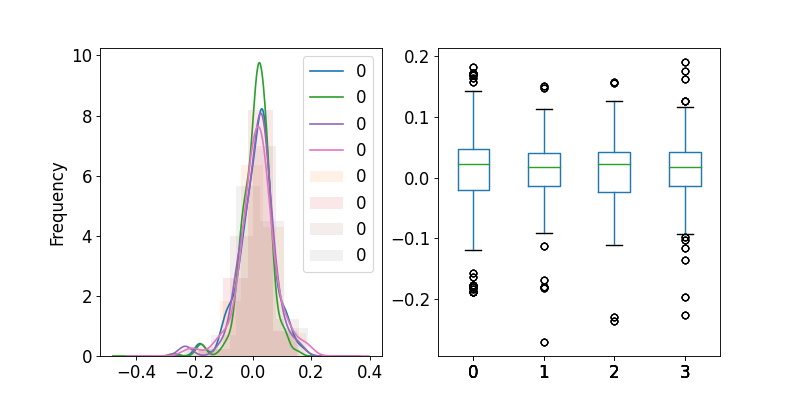

'F-value: 0.17490432932826783, P-value: 0.7655784159919291, Fail to reject null hypothesis.'

In [34]:
anova(fund_type_returns_dict["Large Growth"],
      fund_type_returns_dict['Large Value'],
      fund_type_returns_dict['Large Blend'],
      fund_type_returns_dict['Mid-Cap Growth'])

Compare to equivalent SciPy function: 

In [35]:
stats.f_oneway(fund_type_returns_dict["Large Growth"],
               fund_type_returns_dict['Large Value'],
               fund_type_returns_dict['Large Blend'],
               fund_type_returns_dict['Mid-Cap Growth'])

F_onewayResult(statistic=0.174904329328268, pvalue=0.9134057926962882)

These results suggest that almost all of the total variance in the data is caused by within-data variance, not between-data variance. The practical interperetation is that the type of mutual fund does not significantly change yearly returns. This result may support the EMH because specific specialization of funds has no effect on returns. The market gave the same returns to the funds no matter their specialization. 